# MCMC Example for Chelyabinsk

In [2]:
import sys
sys.path.append('../')
import numpy as np
from fragmentationmodel.planet import Planet
from fragmentationmodel.solver import MCMCSolver, denormalize
import matplotlib.pyplot as plt
import copy
import pprint
import json
import logging

logger = logging.getLogger('fragmentationmodel')
logger.setLevel(logging.ERROR)

## Create the model definition function

To build the model, we need a base config (i.e., defining immutable input parameters) and then a list of parameters that we allow the MCMC search to vary. For this Chelyabinsk test case, we can load the config that we used in the test case (see `Chelyabinsk.ipynb`)

In [2]:
with open('chelyabinsk.json', 'r') as infile:
    base_config = json.load(infile)

pprint.pprint(base_config)

{'fragments': [{'C_fr': 1.5,
                'ablation_coefficient': 6e-09,
                'alpha': 0.0,
                'bulk_density': 3300.0,
                'initial_mass': 296250.0,
                'initial_strength': 10500000.0,
                'release_pressure': 975000.0}],
 'main_body': {'C_fr': 1.5,
               'ablation_coefficient': 6e-09,
               'alpha': 0.18,
               'bulk_density': 3300.0,
               'initial_height': 45000.0,
               'initial_mass': 11850000.0,
               'initial_strength': 300000.0,
               'release_pressure': 0}}


### Create the parameter space for the MCMC solver to search

We create list of MCMC parameter by defining a dictionary, where each parameter name is the key and the value is a dictionary with the following keys:

   * `min`: the minimum value allowed for this parameter
   * `max`: the maximum value allowed for this parameter
   * `location`: the location of this parameter in the configuration dictionary (with nested values separated by '.'). For example, the first fragment's initial mass fraction will have a location `fragment.1.initial_mass_fraction`, which matches the structure in the original dictionary

In [3]:
parameters = {
    'v': {'min': 12000., 'max': 22000., 'location': 'main_body.initial_velocity'},
    'theta': {'min': 0., 'max': 45., 'location': 'main_body.initial_angle'},
    'Ch': {'min': 1e-9, 'max': 1e-8, 'location': 'main_body.ablation_coefficient'},
    'sigma': {'min': 0.1e6, 'max': 1e6, 'location': 'main_body.initial_strength'},
    'rho_d': {'min': 1000., 'max': 5000., 'location': 'main_body.bulk_density'},
    'M_frac': {'min': 0.01, 'max': 0.05, 'location': 'fragment.1.initial_mass_fraction'},
    'P_release_frag': {'min': 0.5e6, 'max': 4e6, 'location': 'fragment.1.release_pressure'},
    'sigma_frag': {'min': 5e6, 'max': 15e6, 'location': 'fragment.1.initial_strength'},
}

### Initializing the solver
With the base configuration and the search parameters defined, we can initialize the solver by defining the planet properties, and setting the reference lightcurve

In [4]:
planet = Planet("Earth")
planet.define_temperature_profile('earthtp/chelyabinsk_50k.tp')

solver = MCMCSolver(base_config, planet)
solver.set_parameters(parameters)

# get the observed energy deposition profile
energydepdata = np.loadtxt('energydep/ChelyabinskEnergyDep_Wheeler-et-al-2018.txt', skiprows=1)

solver.set_lightcurve(energydepdata[:, 0] * 1e3, energydepdata[:, 1], 0.01, 'energy_deposition')
solver.set_integration_parameters({'dt': 5e-3, 'max_time': 25.})

### Run the solver

Run the solver by calling the `run_mcmc` method. The main arguments are the number of steps, the number of simultaneous walkers and (optionally) the number of processors to use for parallelization

In [5]:
sampler = solver.run_mcmc(num_steps=100, n_walkers=32, threads=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:58<00:00,  4.18s/it]


### Analyzing the solver output

We can look at how the solver compares to the known values to see how well the solver works

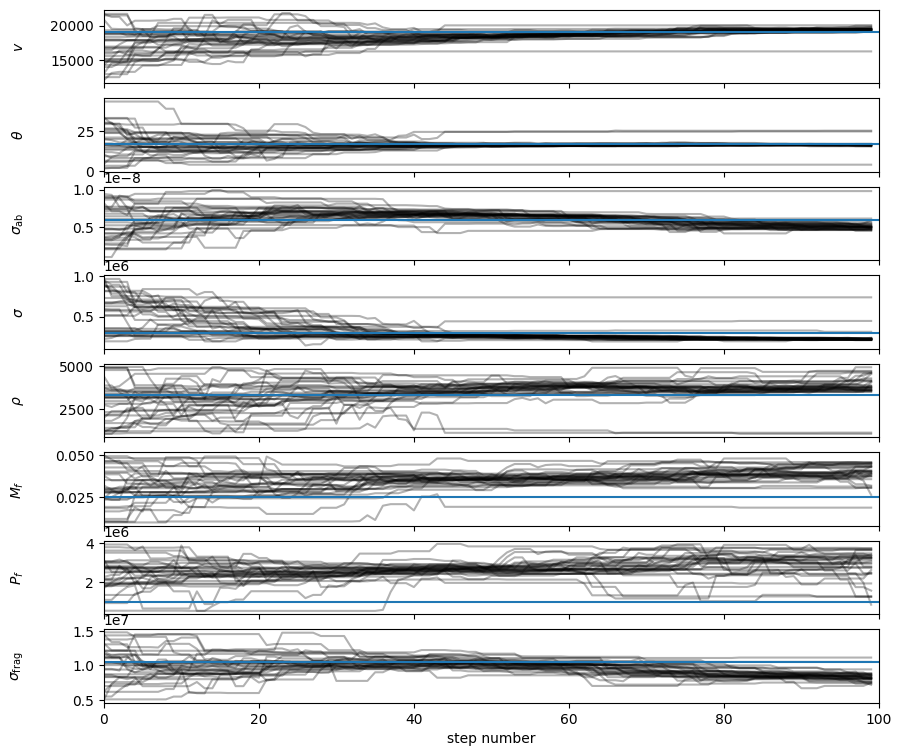

In [6]:
fig, axes = plt.subplots(solver.ndims, figsize=(10, 9), sharex=True)
samples = solver.sampler.get_chain()

labels = [r'$v$', r'$\theta$', r'$\sigma_{\rm ab}$', r'$\sigma$', r'$\rho$', r'$M_f$', r'$P_f$', r'$\sigma_{\rm frag}$']
truths=[19040, 17, 0.12 / 2e7, 0.3e6, 3300, 0.025, 0.975e6, 10.5e6]

for i in range(solver.ndims):
    ax = axes[i]
    param = solver.parameters[solver.parameter_names[i]]
    ax.plot(denormalize(samples[:, :, i], param['min'], param['max']), "k", alpha=0.3)
    ax.axhline(truths[i])
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

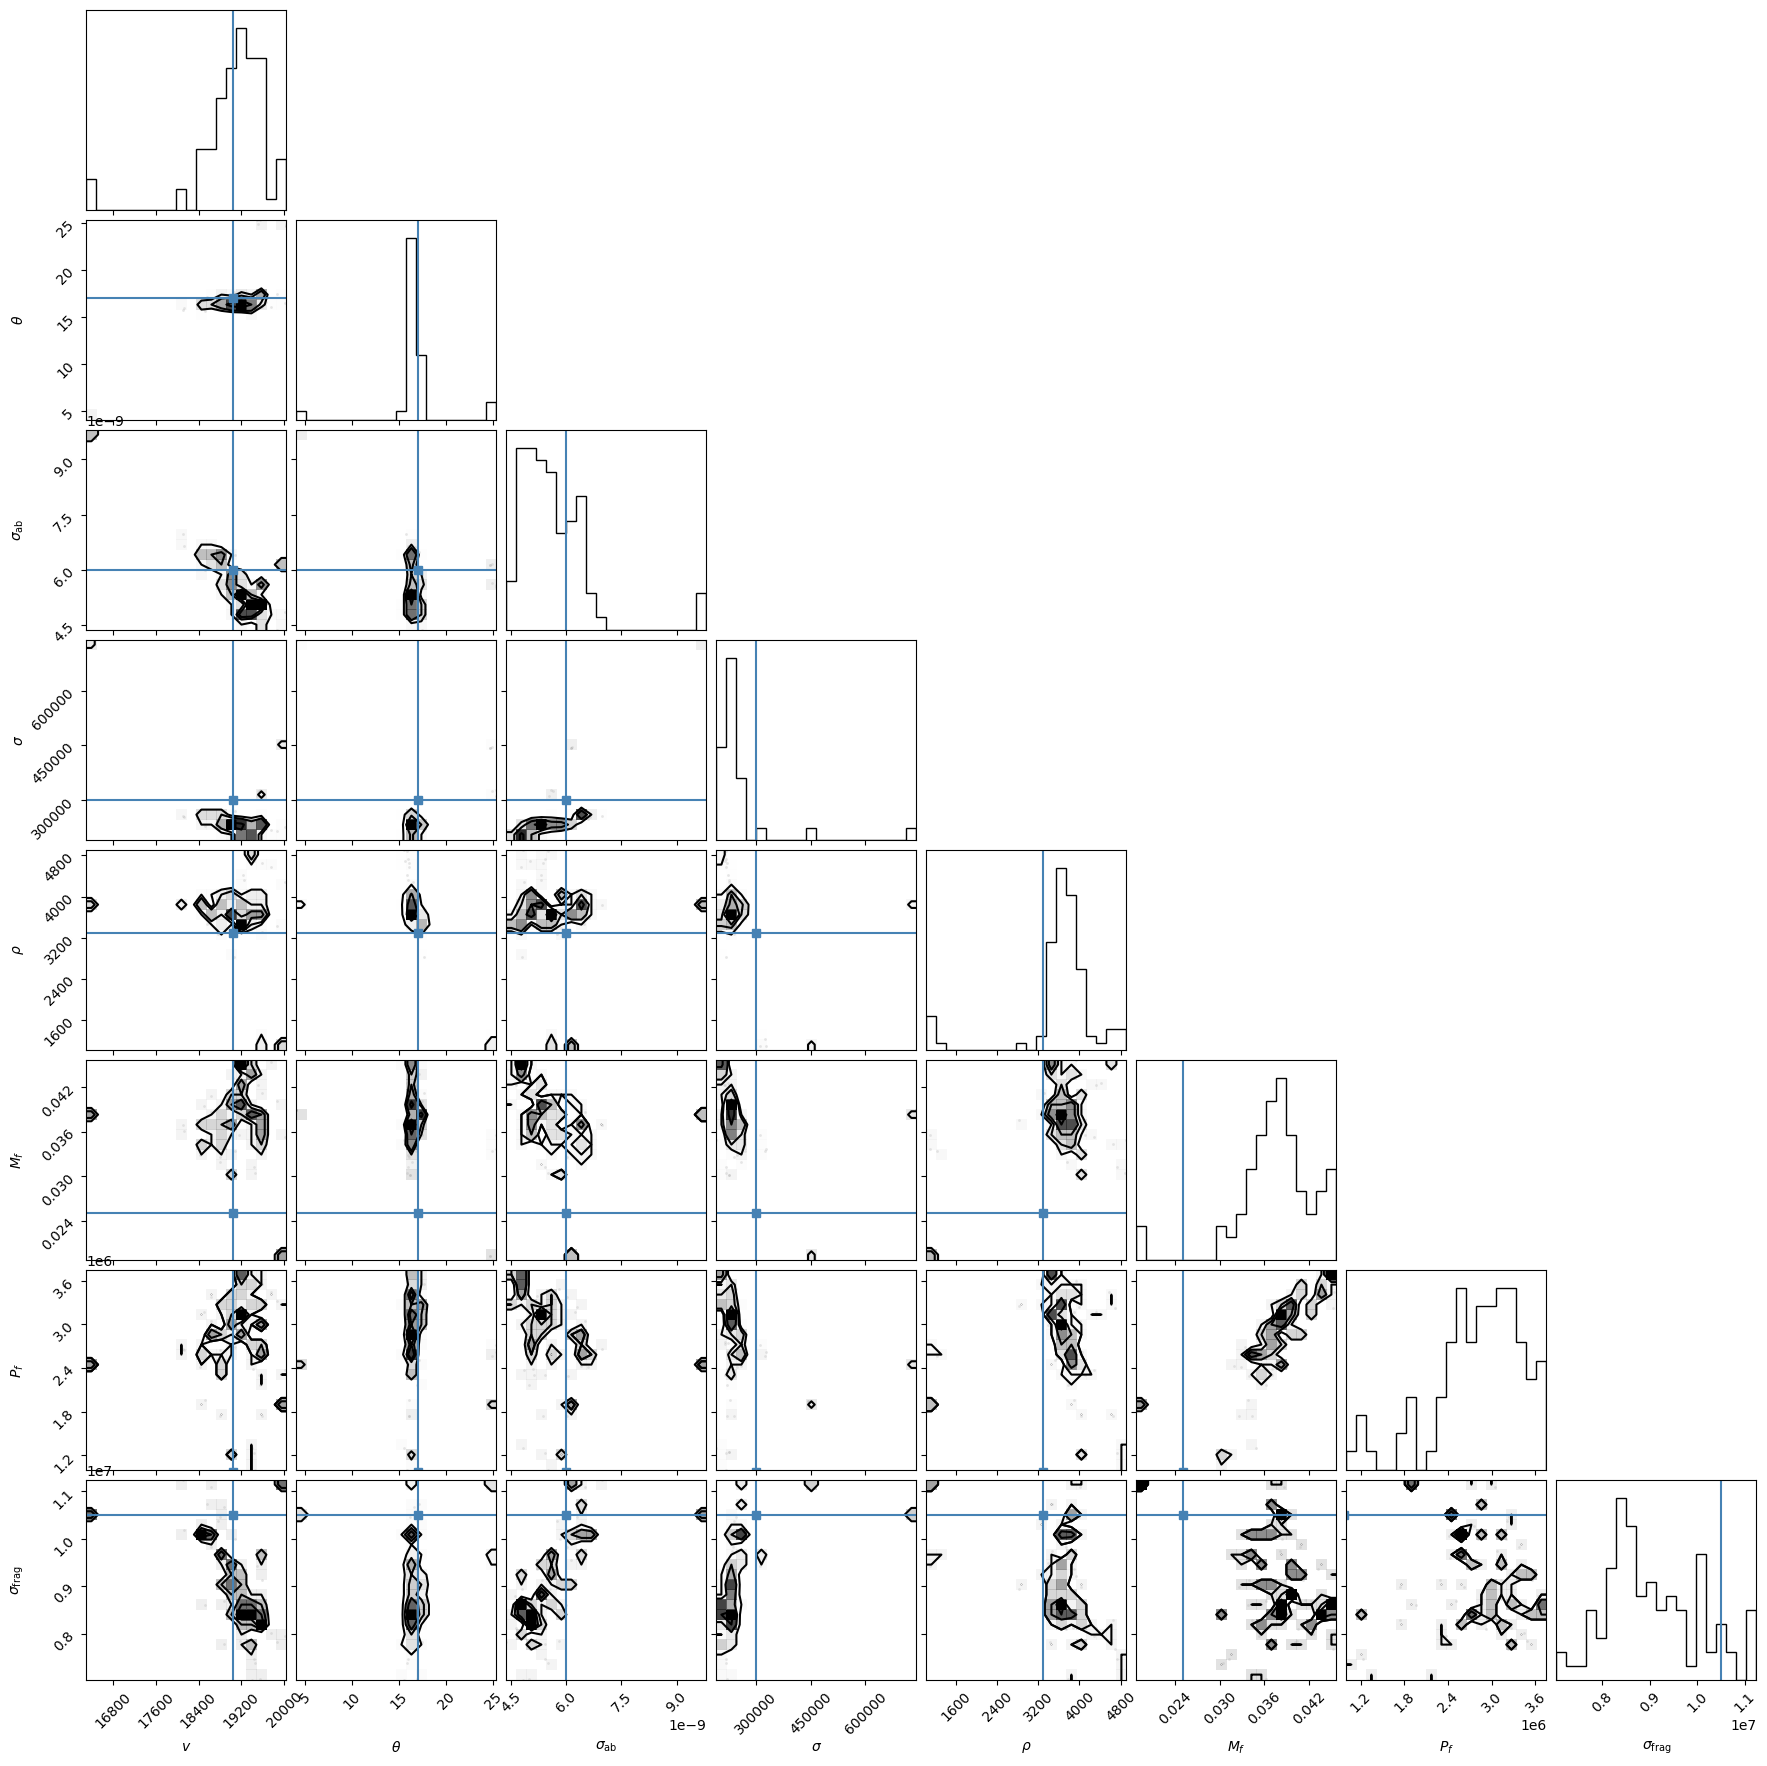

In [7]:
import corner
flat_samples = solver.sampler.get_chain(discard=50, thin=15, flat=True)
# de-normalize the values
for i in range(solver.ndims):
    param = solver.parameters[solver.parameter_names[i]]
    flat_samples[:, i] = denormalize(flat_samples[:, i], param['min'], param['max'])

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);

It's also useful to run the model again with the solver's solutions. We can do this easily by taking the input configuration and running the `Solver.get_config(new_config)` method, which will return a `FragmentationModel` object with the new loaded parameters. We can then integrate this forward to see the results

In [8]:
mcmc = np.percentile(solver.sampler.get_chain(discard=50, thin=15, flat=True), 50, axis=0)

frag_model_best = solver.get_new_config(mcmc)
df = frag_model_best.integrate(**solver.integration_parameters)

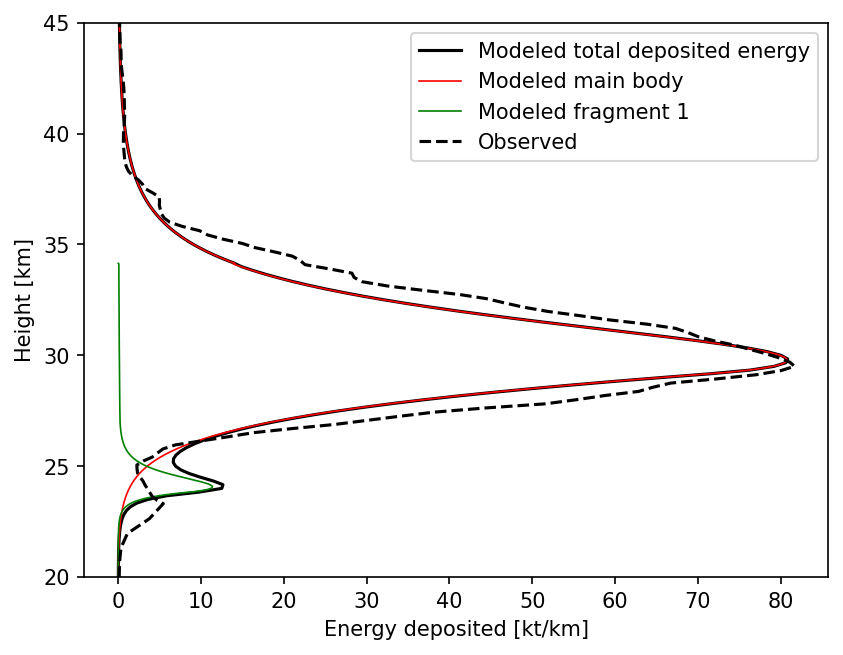

In [9]:
fig, ax = plt.subplots(1, 1, dpi=150)

# 1 kt in joules
kt = 4.184e12

# we need to interpolate the energy deposition curves from the different fragments
# onto the same height grid because they are traveling at different velocities
height = np.linspace(20, 45, 151) * 1e3
# flip the order since np.interp expects sorted x values
f1_deposited = np.interp(height, df['f1.height'][::-1], df['f1.deposited'][::-1]  * (1000 / kt))
main_deposited = np.interp(height, df['main.height'][::-1], df['main.deposited'][::-1]  * (1000 / kt))
ax.plot((main_deposited + f1_deposited), height / 1e3, 'k-', label='Modeled total deposited energy')

# plot the individual energy deposition curves
ax.plot(df['main.deposited'] * (1000 / kt), df['main.height']/1000., 'r-', label='Modeled main body', linewidth=0.8)
ax.plot(df['f1.deposited'] * (1000 / kt), df['f1.height']/1000., 'g-', label='Modeled fragment 1', linewidth=0.8)

# plot the observed data
ax.plot(energydepdata[:,1], energydepdata[:,0], 'k--', label='Observed')
ax.set_ylim((20., 45.))
ax.set_xlabel(r'Energy deposited [kt/km]')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

It looks like the solver has underestimated the fragment strength. So we can rerun the solver by keeping the main body parameters fixed, but prescribing a higher fragment strength. So let's get the config from the model and just tell the MCMC solver to change the fragment strength and mass fraction

In [10]:
base_config = copy.deepcopy(frag_model_best.get_config())  # copy the dict since we don't want to modify the dictionary in place

parameters = {
    'M_frac': {'min': 0.01, 'max': 0.05, 'location': 'fragment.1.initial_mass_fraction'},
    'P_release_frag': {'min': 0.5e6, 'max': 4e6, 'location': 'fragment.1.release_pressure'},
    'sigma_frag': {'min': 8e6, 'max': 15e6, 'location': 'fragment.1.initial_strength'},
}

planet = Planet("Earth")
planet.define_temperature_profile('earthtp/chelyabinsk_50k.tp')

solver = MCMCSolver(base_config, planet)
solver.set_parameters(parameters)

# get the observed energy deposition profile
energydepdata = np.loadtxt('energydep/ChelyabinskEnergyDep_Wheeler-et-al-2018.txt', skiprows=1)

solver.set_lightcurve(energydepdata[:, 0] * 1e3, energydepdata[:, 1], 0.01, 'energy_deposition')
solver.set_integration_parameters({'dt': 5e-3, 'max_time': 25.})

In [11]:
sampler = solver.run_mcmc(num_steps=100, n_walkers=32, threads=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:36<00:00,  3.37s/it]


Let's see the model changed here

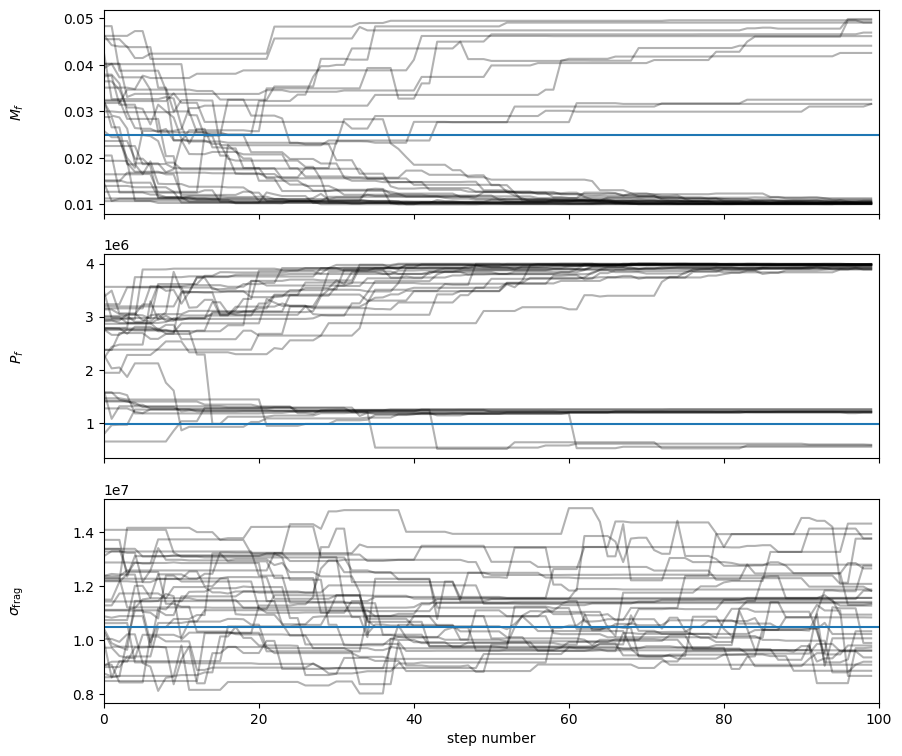

In [12]:
fig, axes = plt.subplots(solver.ndims, figsize=(10, 9), sharex=True)
samples = solver.sampler.get_chain()

labels = [r'$M_f$', r'$P_f$', r'$\sigma_{\rm frag}$']
truths=[0.025, 0.975e6, 10.5e6]

for i in range(solver.ndims):
    ax = axes[i]
    param = solver.parameters[solver.parameter_names[i]]
    ax.plot(denormalize(samples[:, :, i], param['min'], param['max']), "k", alpha=0.3)
    ax.axhline(truths[i])
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
mcmc = np.percentile(solver.sampler.get_chain(discard=50, thin=15, flat=True), 50, axis=0)

frag_model_best = solver.get_new_config(mcmc)
df = frag_model_best.integrate(**solver.integration_parameters)

In [16]:
pprint.pprint(frag_model_best.get_config())

{'fragments': [{'C_fr': 1.5,
                'ablation_coefficient': np.float64(5.456993047349999e-09),
                'alpha': 0.0,
                'bulk_density': np.float64(3737.113100101885),
                'initial_mass': np.float64(128642.4981120732),
                'initial_strength': np.float64(11120746.262040611),
                'release_pressure': np.float64(3897249.5660145585)}],
 'main_body': {'C_fr': 1.5,
               'ablation_coefficient': np.float64(5.456993047349999e-09),
               'alpha': 0.18,
               'bulk_density': np.float64(3737.113100101885),
               'initial_angle': np.float64(16.64747063623527),
               'initial_height': 45000.0,
               'initial_mass': 11850000.0,
               'initial_strength': np.float64(231576.22950735135),
               'initial_velocity': np.float64(19193.218034953352),
               'release_pressure': 0}}


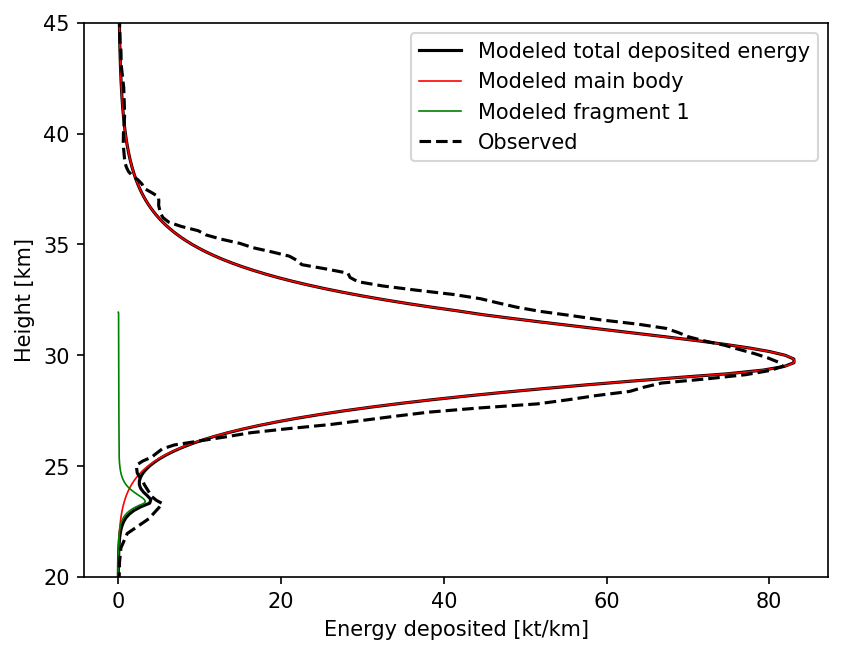

In [14]:
fig, ax = plt.subplots(1, 1, dpi=150)

# 1 kt in joules
kt = 4.184e12

# we need to interpolate the energy deposition curves from the different fragments
# onto the same height grid because they are traveling at different velocities
height = np.linspace(20, 45, 151) * 1e3
# flip the order since np.interp expects sorted x values
f1_deposited = np.interp(height, df['f1.height'][::-1], df['f1.deposited'][::-1]  * (1000 / kt))
main_deposited = np.interp(height, df['main.height'][::-1], df['main.deposited'][::-1]  * (1000 / kt))
ax.plot((main_deposited + f1_deposited), height / 1e3, 'k-', label='Modeled total deposited energy')

# plot the individual energy deposition curves
ax.plot(df['main.deposited'] * (1000 / kt), df['main.height']/1000., 'r-', label='Modeled main body', linewidth=0.8)
ax.plot(df['f1.deposited'] * (1000 / kt), df['f1.height']/1000., 'g-', label='Modeled fragment 1', linewidth=0.8)

# plot the observed data
ax.plot(energydepdata[:,1], energydepdata[:,0], 'k--', label='Observed')
ax.set_ylim((20., 45.))
ax.set_xlabel(r'Energy deposited [kt/km]')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

This improved the error in the fragment's deposition peak somewhat, but the model is struggling to distinguish between the release pressure, and it has severely underestimated the fragment mass (resulting in a lower peak energy release)! At this point, it's probably best to manually tweak the release pressure and try to find the best fit.